## Breast Cancer tutorial

This tutorial demonstrates the application of Renoir on a Triple Negative Breast Cancer visium data available [here](https://www.nature.com/articles/s41588-021-00911-1#data-availability).

In [1]:
import Renoir
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import pickle
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 8]

### Generate neighborhood scores

In [ ]:
neighborhood_scores = Renoir.compute_neighborhood_scores(SC_path='/shared/nr57/Renoir_data/Breast_Cancer_corrected/scRNA.h5ad', ST_path='/shared/nr57/Renoir_data/Breast_Cancer_corrected/ST.h5ad', pairs_path='/home/nr57/top_10_target_opt_both_ordered.csv', ligand_receptor_path='/home/nr57/All_human_lrpairs.csv', celltype_proportions_path='/shared/nr57/Renoir_data/Breast_Cancer_corrected/cell2loc_result/rep1/celltype_proportions.csv', expins_path='/shared/nr57/Renoir_data/Breast_Cancer_corrected/cell2loc_result/rep1/mRNA_subset_new.pkl')

/home/nr57/.conda/envs/genomics/lib/python3.11/site-packages/Renoir/renoir.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_sc = mean_sc.groupby('celltype').mean().T.to_dict()
/home/nr57/.conda/envs/genomics/lib/python3.11/site-packages/Renoir/renoir.py:276: RuntimeWarning: divide by zero encountered in log10
  PEM = np.log10(expins/E)


### Downstream tasks

The generated neighborhood scores can be utilized for a variety of downstream analysis. First, the spatial map of specific ligand-target activity can be viewed as so,

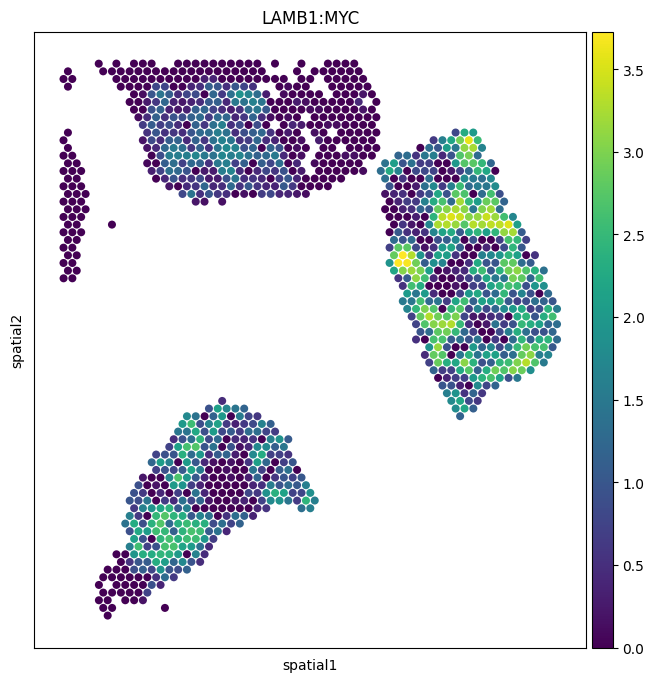

In [3]:
sc.pl.spatial(neighborhood_scores, img_key="hires", color=["LAMB1:MYC"], size = 1.4, alpha_img=0)

Specific pathway sets and De novo ligand-target clusters can be generated using the `create_cluster` function

> **Note**: pathways are to be provided in the format of a pandas dataframe with columns *'gs_name'*, *'gene_symbol'*

In [5]:
#Read in msgidb pathways
msigh = Renoir.get_msig('custom',path='/shared/nr57/Renoir_data/msig_human_WP_H_KEGG_new.csv')
#Generate ligand-target sets for each pathway and/or De novo cluster
pathways = Renoir.create_cluster(neighborhood_scores, msigh, method=None, restrict_to_KHW=True)
pathways.keys()

dict_keys(['HALLMARK_ALLOGRAFT_REJECTION', 'HALLMARK_APICAL_JUNCTION', 'HALLMARK_APOPTOSIS', 'HALLMARK_COAGULATION', 'HALLMARK_COMPLEMENT', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_HYPOXIA', 'HALLMARK_IL2_STAT5_SIGNALING', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_INFLAMMATORY_RESPONSE', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_KRAS_SIGNALING_UP', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_UV_RESPONSE_UP', 'KEGG_ALLOGRAFT_REJECTION', 'KEGG_APOPTOSIS', 'KEGG_AUTOIMMUNE_THYROID_DISEASE', 'KEGG_BLADDER_CANCER', 'KEGG_CELL_ADHESION_MOLECULES_CAMS', 'KEGG_CHEMOKINE_SIGNALING_PATHWAY', 'KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION', 'KEGG_ERBB_SIGNALING_PATHWAY', 'KEGG_FOCAL_ADHESION', 'KEGG_GAP_JUNCTION', 'KEGG_GLIOMA', 'KEGG_GRAFT_VERSUS_HOST_DISEASE', 'KEGG_INTESTINAL_IMMUNE_NETWORK_FOR_IGA_PRODUCTION', 'KEGG_JAK_STAT_SIGNALING_PATHWAY', 'KEGG_LEUKOCYTE_TRANSENDOTHELIAL_MIGRATION', 'KEGG_MAPK_SIGNALING_PATHWAY', 'KEGG_MELANOMA

Communication domains can be generated using the neighborhood scores as so,

In [6]:
neighbscore_copy, pcs = Renoir.downstream_analysis(neighborhood_scores, ltpair_clusters=pathways, resolution=0.6, n_markers=20, n_top=20, pdf_path=None, return_cluster=True, return_pcs=True)

/home/nr57/.conda/envs/genomics/lib/python3.11/site-packages/Renoir/downstream.py:182: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pcs = pcs.applymap(abs)
/home/nr57/.conda/envs/genomics/lib/python3.11/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/nr57/.conda/envs/genomics/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nr57/.conda/envs/genomics/lib/python3.11/site-packages/Renoir/downstream.py:227: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to w

The communication domains and pathway activity can be visualized as follows,

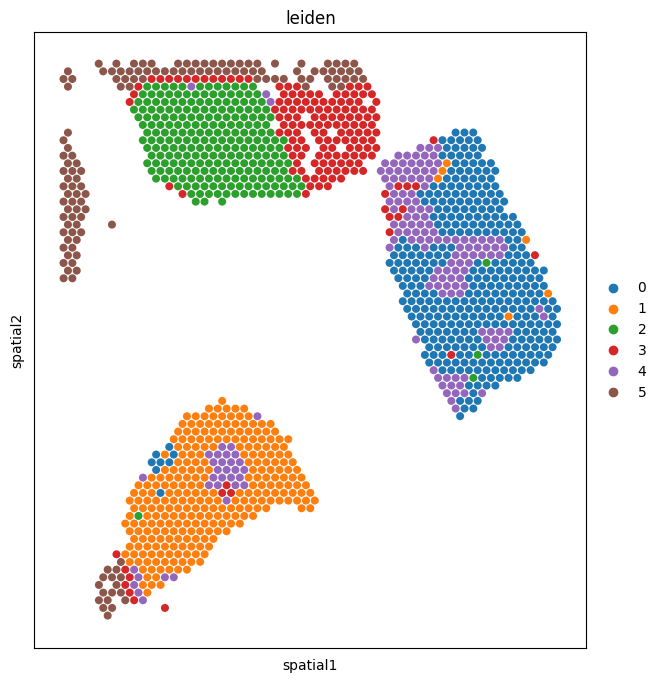

In [7]:
sc.pl.spatial(neighbscore_copy, img_key="hires", color=["leiden"], size=1.4, alpha_img=0)

In [10]:
neighborhood_scores.obs['leiden'] = neighbscore_copy.obs['leiden']
neighborhood_scores.uns = neighbscore_copy.uns

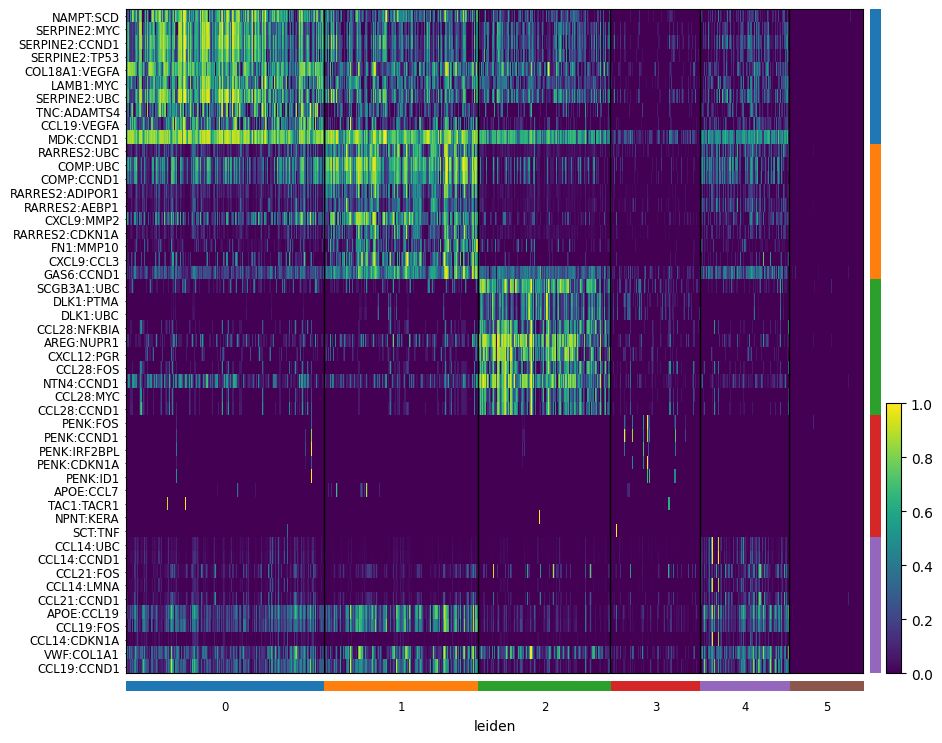

In [11]:
sc.tl.rank_genes_groups(neighborhood_scores, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups_heatmap(neighborhood_scores, n_genes=10, groupby="leiden", show_gene_labels=True, min_logfoldchange=0.5, dendrogram = False, swap_axes=True, standard_scale='var', cmap='viridis')

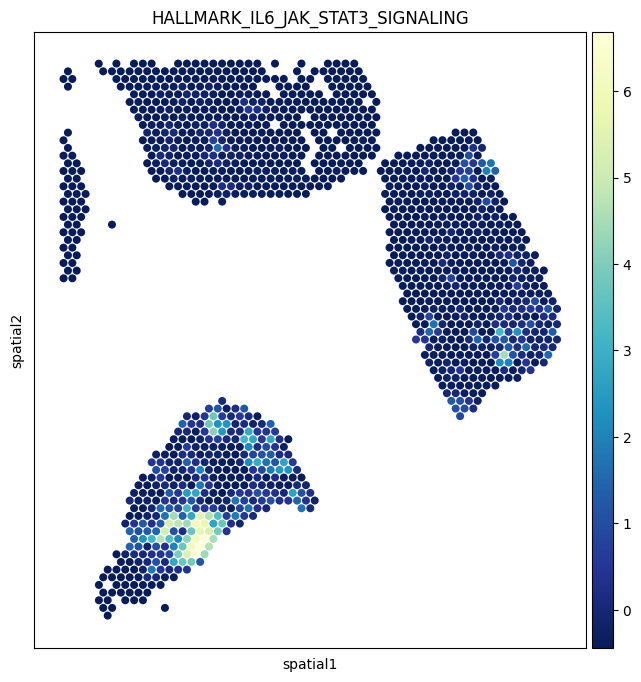

In [13]:
sc.pl.spatial(pcs, img_key="hires", color=['HALLMARK_IL6_JAK_STAT3_SIGNALING'], size = 1.4, alpha_img=0, cmap='YlGnBu_r')